Must run from start using run all:

### Importing libraries
This section imports all libraries utilised within the programme

In [16]:
import pandas as pd
import numpy as np
from math import sqrt

# SKLearn
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor

# Graphing
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from ipywidgets import interact, widgets, interactive


'''Global variables
    '''

global gMethodDictionary
global gVarErrorDf
gVarErrorDf = pd.DataFrame(columns=[ 'Drop index','Predicted y', 'RMSE', 'R^2', 'MAE', 'RMSE %', 'R^2 %', 'MAE %'])
gVarNames = ['Cement','Blast Furnace Slag','Fly Ash','Water','Superplasticizer','Coarse Aggregate','Fine Aggregate','Age','Concrete compressive strength',' ']
gX_train_preprocessed = pd.DataFrame()
gX_test_preprocessed = pd.DataFrame()
gy_train = []
gy_test = []


### Data import, handling and preprocessing

        DUPLICATES DROPPED

In [17]:
def csv_import():
    #import data from the files
    dataset = pd.read_csv('Concrete_Data_Yeh_final.csv')

    #Data Preprocessing
    #format as a dataframe
    dataset = pd.DataFrame(dataset)
    
    print(f'Null values: \n', dataset.isnull().sum()) #check for null values
    print(f'Duplicated values:',dataset.duplicated().sum()) #check for duplicates
    dataset = dataset.drop_duplicates() #drop duplicates
    dataset.dtypes #check for data types


    
    y = dataset["csMPa"]
    X = dataset.drop("csMPa", axis=1)

    return X, y

In [18]:
def preprocessing(X,y):
    # Splitting the data into training and test sets
    global gX_train_preprocessed, gX_test_preprocessed
    global gy_train, gy_test    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Creating a preprocessing pipeline that imputes missing values with the mean 
    # and scales features to have zero mean and unit variance.
    preprocessing_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    gX_train_preprocessed = pd.DataFrame(preprocessing_pipeline.fit_transform(X_train))
    gX_test_preprocessed = pd.DataFrame(preprocessing_pipeline.transform(X_test))
    gy_train = y_train
    gy_test = y_test

### Regression functions

This section defines functions for various regression models which are later compared to choose the most effective model.

The regression models included are:

1. **Linear Regression (`linear_regression`)**: This model assumes a linear relationship between the independent and dependent variables. It is simple and provides interpretable results.

2. **Decision Tree Regression (`decision_tree_regression`)**: This model uses a decision tree to predict the dependent variable based on the independent variables. It is a non-parametric method and can capture complex relationships.

3. **Random Forest Regression (`random_forest_regression`)**: This model uses a collection of decision trees to make predictions. It is robust to overfitting and can handle large datasets with many variables.

4. **Lasso Regression (`lasso_regression`)**: This model is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.

5. **Elastic Net Regression (`elastic_net_regression`)**: This model combines the properties of both Ridge Regression and LASSO Regression. It works well on datasets with many features.

6. **Ridge Regression (`ridge_regression`)**: This model is a regularization method that uses L2 regularization to prevent overfitting.

7. **Support Vector Regression (`svr_regression`)**: This model uses the principles of Support Vector Machines for regression purposes. It works well for datasets with high dimensional space.

8. **K-Nearest Neighbors Regression (`knn_regression`)**: This model predicts the value for a new instance by calculating the mean of the 'k' closest instances in the training set.

Each function splits the data into a training set and a test set, fits the model to the training data, makes predictions on the test data, and calculates several metrics to evaluate the performance of the model. These metrics include the R2 score, the mean squared error, and the mean absolute error.

---

In [19]:
def linear_regression(X, y, z, bestFit = {}):

    """
    This function applies the Linear Regression model to the given dataset.

    Parameters:
    X (numpy.ndarray or pandas.DataFrame): The independent variables, i.e., the input for the model.
    y (numpy.ndarray or pandas.Series): The dependent variable, i.e., the output for the model.
    z (numpy.ndarray or pandas.DataFrame): The X_test_ data used to predict the y_pred values.
    
    Returns:
    numpy.ndarray: The predicted values of the dependent variable for the test set.
    """
    
   #Creating the Linear Regression model
    regressor = LinearRegression(**bestFit)

    # Fitting the data
    regressor.fit(X, y)

    # Predicting the data
    y_pred = regressor.predict(z)

    return y_pred

In [20]:
def decision_tree_regression(X, y,z, bestFit = {}):
    """
    This function applies the Decision Tree Regression model to the given dataset.

    Parameters:
    X (numpy.ndarray or pandas.DataFrame): The independent variables, i.e., the input for the model.
    y (numpy.ndarray or pandas.Series): The dependent variable, i.e., the output for the model.
    z (numpy.ndarray or pandas.DataFrame): The X_test_ data used to predict the y_pred values.

    Returns:
    numpy.ndarray: The predicted values of the dependent variable for the test set.
    """
    # Creating the Decision Tree regressor
    regressor = DecisionTreeRegressor(**bestFit)

    # Fitting the data
    regressor.fit(X, y)

    # Predicting the data
    y_pred = regressor.predict(z)
    return y_pred

In [21]:
def random_forest_regression(X, y, z, bestFit = {} ):
    """
    This function applies the Random Forest Regression model to the given dataset.

    Parameters:
    X (numpy.ndarray or pandas.DataFrame): The independent variables, i.e., the input for the model.
    y (numpy.ndarray or pandas.Series): The dependent variable, i.e., the output for the model.
    z (numpy.ndarray or pandas.DataFrame): The X_test_ data used to predict the y_pred values.
    bestFit (dict): Optional. The hyperparameters for the Random Forest Regressor.

    Returns:
    numpy.ndarray: The predicted values of the dependent variable for the test set.
    """
   
    # Creating the Random Forest Regressor
    regressor = RandomForestRegressor(**bestFit)

    # Fitting the data
    regressor.fit(X, y)

    # Predicting the data
    y_pred = regressor.predict(z)

    return y_pred

In [22]:
def perform_lasso(X, y,z, bestFit = {}):
    """
    Perform Lasso Regression on the given data.

    Parameters:
    X : array-like of shape (n_samples, n_features)
        Training data

    y : array-like of shape (n_samples,)
        Target values
        
    z : (numpy.ndarray or pandas.DataFrame):
        The X_test_ data used to predict the y_pred values.

            Returns:
    float
        Mean squared error of the Lasso model.
    """
    # Create and train the model
    model = Lasso(**bestFit)
    model.fit(X, y)

    # Make predictions and evaluate the model
    y_pred = model.predict(z)
    return y_pred

In [23]:
def elastic_net_regression(X, y,z, bestFit = {}):
    """
    This function applies the Elastic Net Regression model to the given dataset.

    Parameters:
    X (numpy.ndarray or pandas.DataFrame): The independent variables, i.e., the input for the model.
    y (numpy.ndarray or pandas.Series): The dependent variable, i.e., the output for the model.
    z (numpy.ndarray or pandas.DataFrame): The X_test_ data used to predict the y_pred values.

    Returns:
    numpy.ndarray: The predicted values of the dependent variable for the test set.
    """

    # Creating the Elastic Net Regressor
    regressor = ElasticNet(**bestFit)

    # Fitting the data
    regressor.fit(X, y)

    # Predicting the data
    y_pred = regressor.predict(z)

    return y_pred

In [24]:
def ridge_regression(X, y,z, bestFit = {}):
    """
    This function applies the Ridge Regression model to the given dataset.

    Parameters:
    X (numpy.ndarray or pandas.DataFrame): The independent variables, i.e., the input for the model.
    y (numpy.ndarray or pandas.Series): The dependent variable, i.e., the output for the model.
    z (numpy.ndarray or pandas.DataFrame): The X_test_ data used to predict the y_pred values.
    
    Returns:
    numpy.ndarray: The predicted values of the dependent variable for the test set.

    Prints:
    R2 Score: The coefficient of determination, a statistical measure of how well the regression predictions approximate the real data points.
    Mean Squared Error: The average squared difference between the estimated values and the actual value.
    Mean Absolute Error: The average absolute difference between the estimated values and the actual value.
    """
    
    # Creating the Ridge Regressor
    regressor = Ridge(**bestFit)

    # Fitting the data
    regressor.fit(X, y)

    # Predicting the data
    y_pred = regressor.predict(z)

    return y_pred

In [25]:
def perform_svr(X, y,z, bestFit = {}):
    """
    Perform Support Vector Regression (SVR) on the given data.

    Parameters:
    X : array-like of shape (n_samples, n_features)
        Training data

    y : array-like of shape (n_samples,)
        Target values

    z : (numpy.ndarray or pandas.DataFrame)
        The X_test_ data used to predict the y_pred values.

    kernel : string, optional (default='rbf')
        Specifies the kernel type to be used in the algorithm.
        It must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable.

    C : float, optional (default=1.0)
        Regularization parameter. The strength of the regularization is inversely proportional to C.
        Must be strictly positive.

    epsilon : float, optional (default=0.1)
        Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.

    test_size : float, optional (default=0.2)
        Represents the proportion of the dataset to include in the test split.

    random_state : int or RandomState instance, optional (default=None)
        Controls the shuffling applied to the data before applying the split.

    Returns:
    float
        Mean squared error of the SVR model.
    """
    # Create and train the model
    model = SVR(**bestFit)
    model.fit(X, y)

    # Make predictions and evaluate the model
    y_pred = model.predict(z)
    return y_pred

In [26]:
def perform_knn(X, y,z, bestFit = {}):
    """
    Perform K-Nearest Neighbors Regression on the given data.

    Parameters:
    X : array-like of shape (n_samples, n_features)
        Training data

    y : array-like of shape (n_samples,)
        Target values

    z : (numpy.ndarray or pandas.DataFrame)
        The X_test_ data used to predict the y_pred values.

            Returns:
    float
        Mean squared error of the KNN model.
    """

    # Create and train the model
    model = KNeighborsRegressor(**bestFit)
    model.fit(X, y)

    # Make predictions and evaluate the model
    y_pred = model.predict(z)
    return y_pred

In [27]:
gMethodDictionary = [('Linear Regression', linear_regression),
                    ('Decision Tree Regression', decision_tree_regression),
                    ('Random Forest Regression', random_forest_regression),
                    ('Ridge', ridge_regression), 
                    ('Lasso', perform_lasso),
                    ('Elastic Net', elastic_net_regression),
                    ('Support Vector Regression', perform_svr),
                    ('K-Nearest Neighbors Regression', perform_knn)]

### Model Evaluation

Analysing the performance of each regression model to determine which technique most accuratley predicts compressive strength

    

In [28]:
'''print(gy_train.shape)
print(gX_train_preprocessed.shape)

y_= random_forest_regression(gX_train_preprocessed, gy_train, gX_test_preprocessed)
plt.scatter(y_, gy_test)
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.title("Random Forest Regression")
#add a trendline
z = np.polyfit(y_, gy_test, 1)
p = np.poly1d(z)
plt.plot(y_,p(y_), color='red')

plt.show()'''

'print(gy_train.shape)\nprint(gX_train_preprocessed.shape)\n\ny_= random_forest_regression(gX_train_preprocessed, gy_train, gX_test_preprocessed)\nplt.scatter(y_, gy_test)\nplt.xlabel("Predicted values")\nplt.ylabel("Actual values")\nplt.title("Random Forest Regression")\n#add a trendline\nz = np.polyfit(y_, gy_test, 1)\np = np.poly1d(z)\nplt.plot(y_,p(y_), color=\'red\')\n\nplt.show()'

In [29]:
def regression_performance():
    
    """
    This function evaluates the performance of various regression models on the preprocessed training and testing data.

    The function loops over each model in the global `gMethodDictionary`, predicts the target variable for the 
    testing data, and calculates the root mean squared error (RMSE), R^2 score, and mean absolute error (MAE) 
    for the predictions. The results are stored in a DataFrame.

    The function then ranks each model based on each performance metric, with the highest R^2 score and the lowest 
    RMSE and MAE being the best. It calculates a rank sum for each model and identifies the model with the lowest 
    rank sum as the best model.

    Parameters:
    None

    Returns:
    best_model (str): The name of the best model.
    df (pd.DataFrame): A DataFrame containing the performance metrics and ranks for each model.
    """

    data = []
    # Loop over each model
    for model_name, model in gMethodDictionary:
        # Predict values for y using X_test_preprocessed       
        y_pred = model(gX_train_preprocessed, gy_train, gX_test_preprocessed)

        # Calculate RMSE and R^2 score
        rmse = sqrt(mean_squared_error(gy_test, y_pred))
        r2 = r2_score(gy_test, y_pred)
        MAE = mean_absolute_error(gy_test, y_pred)

        # Append the data to the list
        data.append([model_name, y_pred, rmse, r2, MAE])

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=['Model', 'y_pred', 'RMSE', 'R^2','MAE'])

    # Set the model names as the index
    df.set_index('Model', inplace=True)

    # Display the DataFrame
    # Rank each metric, with the highest being the best for R^2 and the lowest being the best for RMSE and MAE
    df['R^2_rank'] = df['R^2'].rank(ascending=False)
    df['RMSE_rank'] = df['RMSE'].rank()
    df['MAE_rank'] = df['MAE'].rank()

    # Calculate the sum of the ranks
    df['rank_sum'] = df['R^2_rank'] + df['RMSE_rank'] + df['MAE_rank']

    # Find the model with the lowest rank sum
    best_model = df['rank_sum'].idxmin()

    # Print the best model
    return best_model, df

Hyperperameters

As shown Random Forrest Regression has the best untuned performance on our dataset and as such we are only analysing hyperperameters for this model:
The most important hyperparameters to tune in a Random Forest model to improve its performance are:

1. `n_estimators`: This is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower.

2. `max_depth`: The maximum depth of the tree. This parameter can help to prevent overfitting. If the max depth is too high, the model may learn too much from the training data and perform poorly on unseen data.

3. `min_samples_split`: The minimum number of samples required to split an internal node. If you increase this parameter, each tree in the forest becomes more constrained as it has to consider more samples at each node.

4. `min_samples_leaf`: The minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree.

5. `max_features`: The number of features to consider when looking for the best split. If set to "auto", then `max_features=sqrt(n_features)`.

6. `bootstrap`: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

Both Random Search and Grid Search are hyperparameter tuning techniques, and each has its own advantages and disadvantages.

**Grid Search** systematically works through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance. The benefit is that it's guaranteed to find the best combination of parameters supplied. However, it can be computationally expensive, especially if the number of parameters or their possible values are large.

**Random Search** sets up a grid of hyperparameter values and selects random combinations to train the model and score. The benefit is that it's not as computationally expensive as Grid Search, and you have more control over how long you want it to run for, as you can set the number of iterations. However, it's not guaranteed to find the best parameters.

In practice, it's often recommended to start with Random Search to narrow down the possible range of values for each hyperparameter, and then use Grid Search within that range to find the best combination.

So, neither is strictly "better" - the best choice depends on your specific situation, including the number of hyperparameters you need to tune, the number of possible values for each hyperparameter, and the computational resources you have available.

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

def random_grid_search():
    """
    This function performs a random grid search to identify the best hyperparameter combination for the Random Forest Regressor model.

    The function first defines a hyperparameter grid, then performs a randomized search to identify the best hyperparameter combination. 
    It then defines a narrower hyperparameter grid around the best hyperparameter combination and performs a grid search to identify the 
    best hyperparameter combination. Finally, it uses the best hyperparameter combination to train the final Random Forest model.

    Parameters:
    None

    Returns:
    None
    """
    '''param_grid = {
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False]
    }'''


    param_grid = {
        'n_estimators': [50, 100, 125, 135, 145, 155, 170], # 7
        'max_depth': [None, 20, 30, 40], #4
        'min_samples_split': [ 2, 3,5, 10], #5
        'min_samples_leaf': [ 1, 2, 5, 10],#4
        'min_impurity_decrease': [0.0, 0.2, 0.4, 0.5],#4
        'max_samples': [None, 0.5, 0.75,  1.0], #4
        'bootstrap': [True, False], #2
        'max_features': ['auto', 'sqrt'] #2


    }
    # Step 5: Perform grid search
    rf_grid = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    rf_grid.fit(gX_train_preprocessed, gy_train)

    # Step 6: Identify the best hyperparameter combination from grid search
    best_grid_params = rf_grid.best_params_

    # Use the best hyperparameter combination to train the final Random Forest model
    final_rf_model = RandomForestRegressor(**best_grid_params)
    final_rf_model.fit(gX_train_preprocessed, gy_train)
    print("Best Random Forrest Parameters:", best_grid_params)
    return best_grid_params


In [31]:
def opt_unopt_random_forest(best_grid_params):
    """
    This function compares the performance of the original unoptimized Random Forest Regressor model with the optimized Random Forest Regressor model.

    The function first trains the original unoptimized Random Forest Regressor model and uses it to predict the target variable for the testing data. 
    It then trains the optimized Random Forest Regressor model and uses it to predict the target variable for the testing data. Finally, it calculates 
    the root mean squared error (RMSE), R^2 score, and mean absolute error (MAE) for the predictions of both models and prints the results.

    Parameters:
    None

    Returns:
    None
    """ 
    # Original unoptimized Random Forest Regression
    y_pred_unoptimized = random_forest_regression(gX_train_preprocessed, gy_train, gX_test_preprocessed)

    # Optimized Random Forest Regression  
    y_pred_optimized = random_forest_regression(gX_train_preprocessed, gy_train, gX_test_preprocessed,best_grid_params)

    # Calculate errors
    rmse_unoptimized = sqrt(mean_squared_error(gy_test, y_pred_unoptimized))
    rmse_optimized = sqrt(mean_squared_error(gy_test, y_pred_optimized))
    r2_unoptimized = r2_score(gy_test, y_pred_unoptimized)
    r2_optimized = r2_score(gy_test, y_pred_optimized)
    mae_unoptimized = mean_absolute_error(gy_test, y_pred_unoptimized)
    mae_optimized = mean_absolute_error(gy_test, y_pred_optimized)

    # Print errors
    print("Unoptimized RMSE:", rmse_unoptimized)
    print("Optimized RMSE:", rmse_optimized)
    print("Unoptimized R^2:", r2_unoptimized)
    print("Optimized R^2:", r2_optimized)
    print("Unoptimized MAE:", mae_unoptimized)
    print("Optimized MAE:", mae_optimized)


## Dropping variables

    var_drop():
Used to create a new data set, dropping all combinations of variables using a binary 'drop index'. This allows us to determine the effect on regression performance when dropping single, pairs, triplets or any other combination of variables. This was chosen to allow us to clearly see and account for variable correlation, and efficiently plot the interactive graphs as shown.

    var_performance():
Taking the dataset from var_drop(): to measure the performance effect of dropping variables

    var_impact_pct():
Calculating the difference in original vs retrained performance for various combinations

In [32]:
def var_drop(dropVar):
    """
    Drops columns from the training and testing datasets based on a binary number.

    Each digit in the binary number corresponds to a column in the datasets. If the digit is 1, the corresponding column is dropped. If the digit is 0, the corresponding column is kept.

    Parameters:
    dropVar (int): A binary number where each digit represents a column in the datasets.

    Returns:
    pandas.DataFrame: The modified training dataset with specified columns dropped. 
    """


    # Convert the binary number to a list of booleans
    bool_list = [bool(int(x)) for x in format(dropVar, '0{}b'.format(len(gX_train_preprocessed.columns)))]

    # Create a list of column names to drop based on the boolean list
    columns_to_drop_train = gX_train_preprocessed.columns[bool_list]
    columns_to_drop_test = gX_test_preprocessed.columns[bool_list]

    # Drop the columns
    datasetTrain_drop = gX_train_preprocessed.drop(columns_to_drop_train, axis=1)
    datasetTest_drop = gX_test_preprocessed.drop(columns_to_drop_test, axis=1)

    return datasetTrain_drop, datasetTest_drop

In [33]:
def var_performance():

    """
    This function evaluates the performance of the best regression model when each variable is dropped one by one.

    The function first identifies the best regression model by calling the `regression_performance` function. 
    It then loops over all variables in the preprocessed training and testing data, dropping one variable at a time 
    and evaluating the performance of the model without that variable. The performance is measured in terms of 
    root mean squared error (RMSE), R^2 score, and mean absolute error (MAE). 

    The function also calculates the variation of each performance metric compared to the base case (i.e., when no 
    variables are dropped). The results are stored in the global DataFrame `gVarErrorDf`.

    Parameters:    None
    Returns:    None
    """
    x_train_drop = gX_train_preprocessed
    x_test_drop = gX_test_preprocessed
    best_model, df = regression_performance()

    for key, model_function in gMethodDictionary:
        if key == best_model:
            break

    for i in range(255):
        x_train_drop, x_test_drop = var_drop(i)
       
        y_pred = model_function(x_train_drop, gy_train, x_test_drop)
        rms_error = sqrt(mean_squared_error(gy_test, y_pred))
        r2_error = r2_score(gy_test, y_pred)
        ma_error = mean_absolute_error(gy_test, y_pred)
        if i == 0:
            rms_var = 1
            r2_var = 1
            ma_var = 1
            rms_base = rms_error
            r2_base = r2_error
            ma_base = ma_error

        else:
            rms_var = rms_error / rms_base
            r2_var = r2_error / r2_base
            ma_var = ma_error / ma_base


        gVarErrorDf.loc[i] = [bin(i), y_pred, rms_error, r2_error, ma_error, rms_var, r2_var, ma_var]

In [34]:
def var_impact_pct():

    """
    This function calculates the impact of each variable on the model's performance metrics (RMSE, R^2, and MAE) 
    when the variable is dropped. It creates a DataFrame that contains the performance metrics for each variable 
    when it's dropped, as well as when no variables are dropped. It also calculates the impact of dropping two 
    variables at a time. 

    The function then ranks each model (i.e., each set of dropped variables) based on the performance metrics, 
    calculates a rank sum for each model, and sorts the DataFrame by the rank sum. The model with the lowest rank 
    sum is considered the best model.

    The DataFrame is printed to the console and also exported to an Excel file named 'impact_df.xlsx'.

    Parameters:    None

    Returns:    None
    """

    impact_df = pd.DataFrame(columns=['Dropped variable: 1','Dropped variable : 2', 'RMSE', 'R^2', 'MAE','RMSE %', 'R^2 %', 'MAE %', ])

    #Single var impact
    for i in range(8):
        index = 2**i
        impact_df.loc[i] = [gVarNames[(7-i)],gVarNames[9], gVarErrorDf.loc[index]['RMSE'], gVarErrorDf.loc[index]['R^2'], gVarErrorDf.loc[index]['MAE'], gVarErrorDf.loc[index]['RMSE %'], gVarErrorDf.loc[index]['R^2 %'], gVarErrorDf.loc[index]['MAE %']]
    #Data frame containing all single variable impacts
    
    impact_df.loc[8] = ["None dropped",'', gVarErrorDf.loc[0]['RMSE'], gVarErrorDf.loc[0]['R^2'], gVarErrorDf.loc[0]['MAE'], gVarErrorDf.loc[0]['RMSE %'], gVarErrorDf.loc[0]['R^2 %'], gVarErrorDf.loc[0]['MAE %']]
    #plot_as_bar(impact_df)  
    
    #double var impact
    l = 9
    for j in range(7):
        #loop from j+1 to 8
        for k in range(j+1,8):
            if j != k:
                index = 2**j + 2**k #7- index to move through gVarNames correctly
                impact_df.loc[l] = [gVarNames[(7-j)], gVarNames[(7-k)], gVarErrorDf.loc[index]['RMSE'], gVarErrorDf.loc[index]['R^2'], gVarErrorDf.loc[index]['MAE'], gVarErrorDf.loc[index]['RMSE %'], gVarErrorDf.loc[index]['R^2 %'], gVarErrorDf.loc[index]['MAE %']]
                l += 1
    #Data frame containing all double variable impacts'''
    
    impact_df['R^2_rank'] = impact_df['R^2'].rank(ascending=False)
    impact_df['RMSE_rank'] = impact_df['RMSE'].rank()
    impact_df['MAE_rank'] = impact_df['MAE'].rank()

    # Calculate the sum of the ranks
    impact_df['rank_sum'] = impact_df['R^2_rank'] + impact_df['RMSE_rank'] + impact_df['MAE_rank']

    # Find the model with the lowest rank sum
    best_model = impact_df['rank_sum'].idxmin()
    #sort the data frame
    impact_df.sort_values(by=['rank_sum'], inplace=True) #This shows that Cement, Age and Blast funrace slag are the most important variables for predicting concrete strength. Removing the other variables imporves the model performance.
     
    impact_df.to_excel('impact_df.xlsx')#export to excel

## Final Predictions
    
Using all information gathered to create a retrained model (Found to be Random Forrest Regression) removing variables found to harm performance. Hyperparameters are re-optimised for this new data set. Results are displayed

In [35]:
def retrain_model_with_drop_variables(impact_df, gX_train_preprocessed, gy_train, gX_test_preprocessed):
    """
    Retrains the best model with the grid search parameters after dropping variables.

    Parameters:
    impact_df (pandas.DataFrame): DataFrame containing the impact of dropping variables on model performance.
    gX_train_preprocessed (pandas.DataFrame): Preprocessed training dataset.
    gy_train (pandas.Series): Target variable for the training dataset.
    gX_test_preprocessed (pandas.DataFrame): Preprocessed testing dataset.

    Returns:
    RandomForestRegressor: Retrained Random Forest Regressor model.
    """

    # Find the index of the 'None Dropped' entry
    none_dropped_index = impact_df[impact_df['Dropped variable: 1'] == 'None Dropped'].index[0]

    # Get the variables to remove from the impact_df
    variables_to_remove = impact_df.loc[impact_df.index < none_dropped_index, 'Dropped variable: 1'].tolist()

    # Remove the variables from the training and testing datasets
    gX_train_preprocessed_drop = gX_train_preprocessed.drop(variables_to_remove, axis=1)
    gX_test_preprocessed_drop = gX_test_preprocessed.drop(variables_to_remove, axis=1)

    # Retrain the best model with the grid search parameters
    final_rf_model_drop = random_forest_regression(gX_train_preprocessed_drop, gy_train, gX_test_preprocessed_drop, **best_model)

    return final_rf_model_drop


In [36]:
from sklearn.model_selection import learning_curve
def final_plot_predictions(final_model, X_test, y_test):
    """
    Plots y_pred vs y_test using the final model and displays a histogram of errors in y_pred.

    Parameters:
    final_model: The final trained model.
    X_test: The preprocessed testing dataset.
    y_test: The target variable for the testing dataset.

    Returns:
    None
    """
    import matplotlib.pyplot as plt

    # Plot y_pred vs y_test using the final model
    y_pred_final = final_model.predict(X_test)

    plt.scatter(y_test, y_pred_final)
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title('y_pred vs y_test using the final model')
    plt.show()

    errors = y_test - y_pred_final

    plt.hist(errors, bins=10)
    plt.xlabel('Errors')
    plt.ylabel('Frequency')
    plt.title('Histogram of Errors in y_pred')
    plt.show()

    def plot_learning_curve(estimator, X, y):
        """
        Plots the learning curve for an estimator.

        Parameters:
        estimator: The estimator model.
        X: The preprocessed training dataset.
        y: The target variable for the training dataset.

        Returns:
        None
        """
        train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='neg_mean_squared_error')

        train_scores_mean = -train_scores.mean(axis=1)
        test_scores_mean = -test_scores.mean(axis=1)

        plt.plot(train_sizes, train_scores_mean, label='Training error')
        plt.plot(train_sizes, test_scores_mean, label='Validation error')
        plt.xlabel('Training set size')
        plt.ylabel('Mean squared error')
        plt.title('Learning Curve')
        plt.legend()
        plt.show()




    As noted, even with a thourough optimisation system, removal of any uncorrelated/multi-correlated variables we were still unable to achieve what we deemed to be an acceptable error using a single regressor model:
        Below: We have used a stacked regressor to improve performance
        Future: As a group we looked into using Tensor Flow to create a neural network predictive model though due to time constraints did not integrate this (also due to constraints withing Jupyter Notebooks)

## Graph Functions

1. `comp_graph()`

    This function is used to compare two or more datasets. It takes as input the datasets to be compared and plots them on the same graph. This is useful for visualizing how different datasets relate to each other.

2. `var_effect_line()`

    The `var_effect_line()` function is used to visualize the effect of a variable on the outcome. It takes as input a variable and an outcome, and plots a line graph showing how changes in the variable affect the outcome. This is useful for understanding the relationship between a variable and the outcome.

3. `var_effect_bar()`

    The `var_effect_bar()` function is used to create a bar chart showing the effect on the various errors, of removing individual variables from the dataset


In [37]:
def comp_graph():
    """
    This function generates a comparative graph of actual vs predicted values for different regression models.

    The function calls the `regression_performance` function to get the best model and a DataFrame containing 
    the predictions of each model. It then creates a scatter plot for each model, comparing the actual and 
    predicted values. The scatter plots are arranged in a grid, with one subplot for each model. Unused subplots 
    are removed.

    The function doesn't return anything. The graph is displayed using `plt.show()`.

    Note: This function relies on the global variable `gy_test` for the actual values. Make sure this variable 
    is defined and properly initialized before calling this function.
    """
    # Number of models taking the data from the data frame in the regression performance function
    best_model, df = regression_performance()
    n_models = len(df)

    # Create a figure and axes with a subplot for each model
    fig, axs = plt.subplots(2, 4, figsize=(15, 10))

    # Flatten the axes array
    axs = axs.flatten()

    # Loop over each model
    for i, (model_name, row) in enumerate(df.iterrows()):
        # Plot y_test vs y_pred
        axs[i].scatter(gy_test, row['y_pred'], s=10)
        axs[i].plot([gy_test.min(), gy_test.max()], [gy_test.min(), gy_test.max()], 'k--', lw=2)
        axs[i].set_xlabel('Actual')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title(f'{model_name}')
        axs[i].minorticks_on()
        axs[i].grid(False)

    # Remove unused subplots
    for i in range(n_models, len(axs)):
        fig.delaxes(axs[i])

    # Display the plot
    plt.tight_layout()

    plt.show()

In [38]:
def var_effect_line():

    checkboxes = [widgets.Checkbox(value=True, description=var) for var in gVarNames[0:8]]

    def update_lines(*args, **kwargs):
        clear_output(wait=True)
        sns.set_style("whitegrid")  
        
        fig, ax = plt.subplots(figsize=(10, 6))
        plt.size=(10, 6)

        fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)  # Center the plot
        active_vars = [var.description for var in checkboxes if var.value]
        binary_string = ''.join(['1' if not checkbox.value else '0' for checkbox in checkboxes])
        print(f'Drop Index: {binary_string}')
        binary_int = int(binary_string,2)
        x = gy_test
        y = gVarErrorDf.loc[(binary_int)].iloc[1]
        ax.scatter(x, y, label='Data')  # Add a label to the scatter plot
        
        # Fit a line to the data
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        
        # Add the line to the plot
        ax.plot(x, p(x), "r--", label='Trendline')  # Add a label to the trendline
        
        plt.xticks(fontsize=12)  # Increase the size of the x-axis labels
        plt.yticks(fontsize=12)  # Increase the size of the y-axis labels
        
        # Add title
        plt.title('Scatter plot of y_test vs gVarErrorDf', fontsize=16)  # Increase the size of the title
        
        # Add legend
        plt.legend(bbox_to_anchor=(1.05, 1))
        
        # Add axis labels
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        
        ax = plt.gca()
        ax.grid(False)
        ax.minorticks_on()
        
        # Adding a text box containing each error metric rounded to 4 decimal places
        rmse = round(gVarErrorDf.loc[binary_int].iloc[2], 4)
        r2 = round(gVarErrorDf.loc[binary_int].iloc[3], 4)
        mae = round(gVarErrorDf.loc[binary_int].iloc[4], 4)
        text_box = f'RMSE = {rmse}\nR^2 = {r2}\nMAE = {mae}'
        plt.text(0.05, 0.95, text_box, transform=ax.transAxes, verticalalignment='top', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  # Increase the size of the text and add a box
        
        textstr ='''
                    This scatter plot shows the relationship between the actual and 
                    predicted values of Compressive Strength. A trendline is shown in red. 
                    Each point on the plot represents a data point. The position of
                    a point on the x-axis represents its actual value, and the position on 
                    the y-axis represents its predicted value. The text box in the top left 
                    corner shows the effect of removing each variable on the error metrics. 
                    The RMSE, R^2, and MAE values are calculated with each variable removed, 
                    and are rounded to 4 decimal places. RMSE is the Root Mean Square Error,
                    a measure of the differences between values predicted by a model and the 
                    values actually observed.'''
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)


        plt.show()
        

    # 8 checkboxes
    grid = [
        [checkboxes[i] for i in range(j, j+4)]
        for j in range(0, 8, 4)
    ]

    grid = [[checkboxes[i] for i in range(j, j + 4)] for j in range(0, 8, 4)]
    ui = widgets.VBox([widgets.HBox(row) for row in grid])
    out = widgets.interactive_output(update_lines, {checkbox.description: checkbox for checkbox in checkboxes})

    display(ui, out)

In [39]:
def var_effect_bar():
    # List of binary variable names
    index = [bin(2**i) for i in range(8)] #index = ['0b1', '0b10'...
    
    # List of error types
    error_types = ['RMSE', 'R^2', 'MAE']

    def plot_bar_chart(error_type):
        # Get the values for each variable from gVarErrorDf
        plt.figure(figsize=(10, 6))
        global gVarNames
        values = []
        for name in index:
            row = gVarErrorDf.loc[gVarErrorDf['Drop index'] == name, error_type]
            if len(row) > 0:
                values.append(row.values[0])
            else:
                values.append(np.nan)  # replace None with np.nan
        

        plt.bar(gVarNames[0:8], values[::-1]) #Corrects order of names vs values, do to drop index being in reverse order
        plt.title(f'Bar chart of {error_type} after removing variable')
        plt.xlabel('Variable', fontsize=14, labelpad=10)
        plt.ylabel(error_type, fontsize=14)

        # Add a constant line for the baseline (no variables removed)
        baseline = gVarErrorDf.loc[gVarErrorDf['Drop index'] == '0b0', error_type].values[0]
        plt.axhline(y=baseline, color='r', linestyle='--')

        plt.legend(['Baseline', 'Variable'])
        plt.xticks(rotation=90)
        
        ax = plt.gca()
        plt.grid(False)
        
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

        textstr = 'This graph shows the effect of removing each variable on the ' + error_type + '.\n' \
              'The red dashed line represents the baseline (no variables removed).\n' \
              'Use the dropdown menu to select the error type.'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        plt.show()

    # Create dropdown menu for error types
    interact(plot_bar_chart, error_type=error_types)

In [40]:
def visualize_rf_trees(rf_model, num_trees=1):
    """
    This function visualizes the first 'num_trees' trees in a Random Forest model.

    Parameters:
    rf_model (sklearn.ensemble.RandomForestRegressor): The trained Random Forest model.
    num_trees (int): The number of trees to visualize. Default is 1.
    """
    for i in range(num_trees):
        plt.figure(figsize=(20,10))  # Set the figure size
        plot_tree(rf_model.estimators_[i], filled=True)  # Plot the i-th decision tree
        plt.show()

#rf_model, y_pred = random_forest_regression(gX_train_preprocessed, gy_train, gX_test_preprocessed)
#visualize_rf_trees(rf_model, num_trees=3)

## Function: main()

The `main()` function is the entry point of the program. It is responsible for coordinating the execution of other functions and controlling the flow of the program.



Null values: 
 cement               0
slag                 6
flyash               1
water                8
superplasticizer    14
coarseaggregate      7
fineaggregate        3
age                  5
csMPa                0
dtype: int64
Duplicated values: 23
Preprocessing done


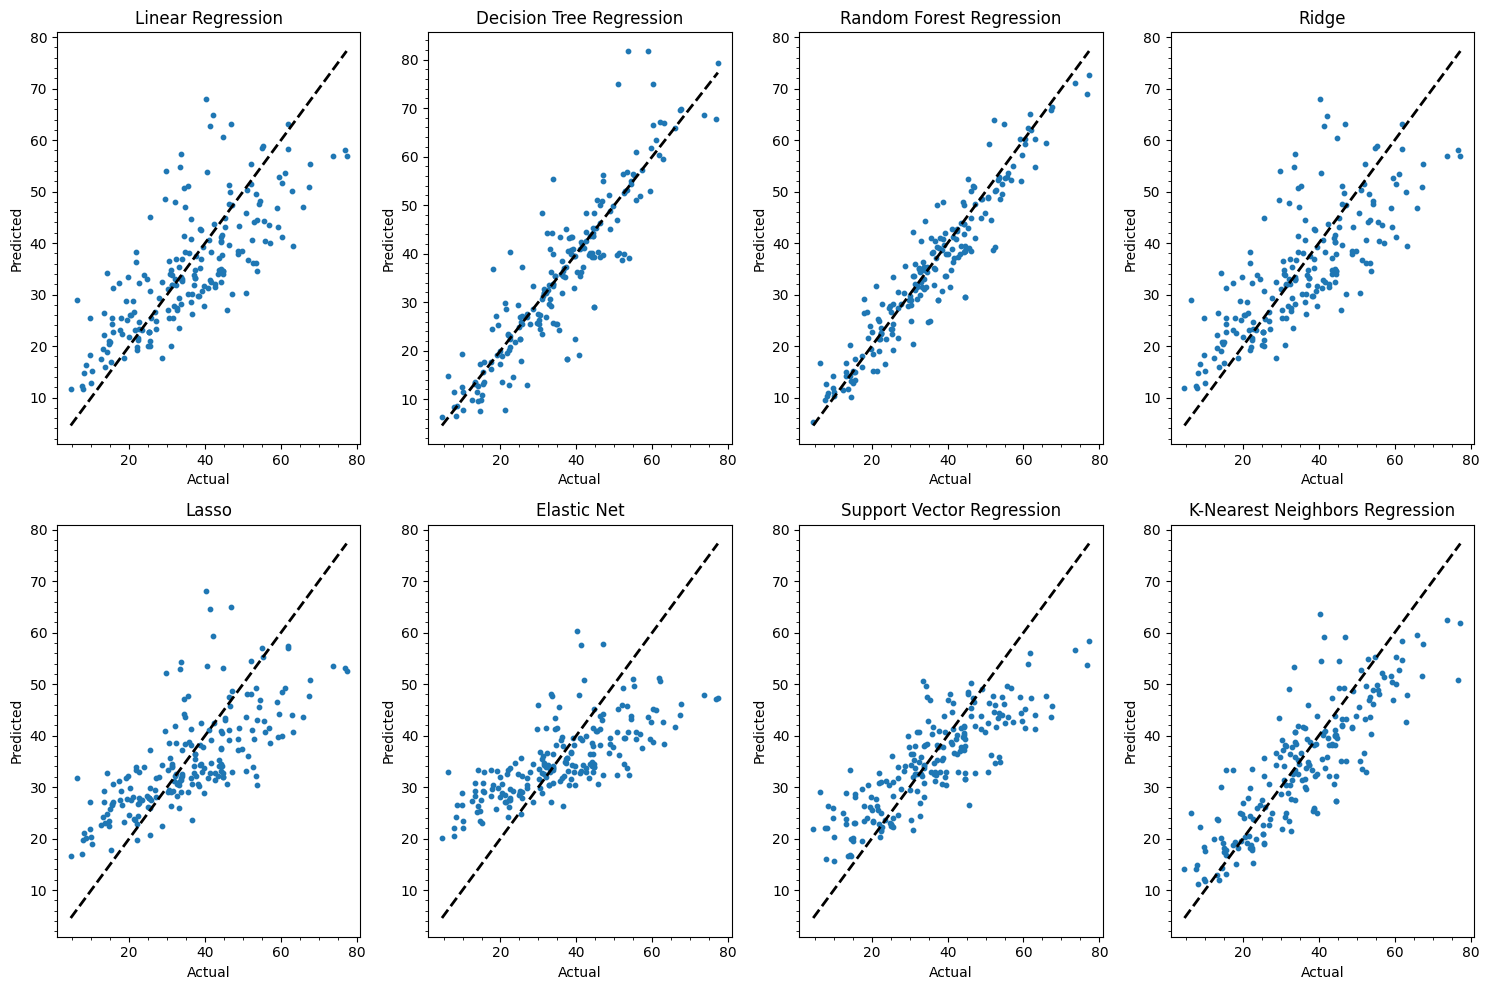

The best model is:  Random Forest Regression 

Performing grid search 

Fitting 5 folds for each of 28672 candidates, totalling 143360 fits


c:\Users\dougl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
53760 fits failed out of a total of 143360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
53760 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dougl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dougl\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 379, in fit
    raise ValueError(
ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`.

  warnings.warn(some_fits_failed_message, FitFailedWarning

Best Random Forrest Parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 155}
********Time taken for grid search: 3919.159449338913 seconds********

Grid search complete. Errors are as follows:
Unoptimized RMSE: 4.738176380746752
Optimized RMSE: 4.095707721005743
Unoptimized R^2: 0.9020758456540542
Optimized R^2: 0.9268313071588204
Unoptimized MAE: 3.589118396982554
Optimized MAE: 2.973965825614818


In [41]:
import time

def main():
    X,y = csv_import()
    preprocessing(X,y)
    print("Preprocessing done")
    comp_graph()
    best_model, df = regression_performance()
    print("The best model is: ", best_model, '\n')
    
    # Hyperparameter tuning
    print("Performing grid search \n")
    start_time = time.time()  # Start the timer
    best_grid_params = random_grid_search()
    end_time = time.time()  # End the timer
    print("********Time taken for grid search:", end_time - start_time, "seconds********\n")
    print("Grid search complete. Errors are as follows:")
    opt_unopt_random_forest(best_grid_params)
    
    #var_performance
    #var_performance()
    #gVarErrorDf.to_csv('var_performance.csv')
    #print(gVarErrorDf)
    #var_impact_pct()
    #print("Var performance done") 
    #var_effect_line() 
    #var_effect_bar()

main()